### **Comparación de Estrategias de Tuning Automático: Optuna vs. Ray Tune**

  * **Objetivo:** Aplicar y comparar las librerías **Optuna** y **Ray Tune** para optimizar los hiperparámetros de un modelo `RandomForestClassifier`. El rendimiento se evaluará sobre el conjunto de datos de Cáncer de Mama de Scikit-learn, utilizando el F1-score como métrica principal.
  * **Modelo:** RandomForestClassifier
  * **Dataset:** Breast Cancer Wisconsin (Diagnostic)
  * **Métrica:** F1-Score

-----

### 1\. Carga y Preprocesamiento de Datos 📊

Primero, cargamos el conjunto de datos de cáncer de mama directamente desde `scikit-learn`. Este dataset contiene 569 muestras y 30 características numéricas. La tarea es clasificar los tumores como **malignos (0)** o **benignos (1)**.

El preprocesamiento es un paso crucial:

  * **Separación de Variables:** Dividimos el dataset en características (`X`) y la variable objetivo (`y`).
  * **División de Datos:** Particionamos los datos en un conjunto de entrenamiento (70%) y uno de prueba (30%). Usamos `random_state` para asegurar la reproducibilidad de los resultados.
  * **Escalado de Variables:** Aplicamos `StandardScaler` para estandarizar las características. Esto asegura que todas las variables tengan la misma escala (media 0 y desviación estándar 1), lo cual es fundamental para el rendimiento de muchos algoritmos de Machine Learning.

<!-- end list -->

In [2]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 12.5 MB/s eta 0:00:00


In [3]:
!pip install ray[tune]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.9/68.9 MB 8.5 MB/s eta 0:00:00


In [4]:
# Importación de librerías necesarias
import pandas as pd
import time
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report
import optuna
import ray
from ray import tune

# 1. CARGA Y PREPROCESAMIENTO

# Cargar el conjunto de datos de cáncer de mama
cancer_dataset = load_breast_cancer()
# Crear un DataFrame de pandas para facilitar la manipulación
# Las características están en 'data' y los nombres de las columnas en 'feature_names'
X = pd.DataFrame(cancer_dataset.data, columns=cancer_dataset.feature_names)
# La variable objetivo (0: maligno, 1: benigno) está en 'target'
y = pd.Series(cancer_dataset.target)

# Dividir los datos en conjuntos de entrenamiento (70%) y prueba (30%)
# random_state=42 asegura que la división sea siempre la misma para reproducibilidad
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Inicializar el escalador estándar
scaler = StandardScaler()
# Ajustar el escalador SÓLO con los datos de entrenamiento para evitar fuga de datos
# y transformar el conjunto de entrenamiento
X_train_scaled = scaler.fit_transform(X_train)
# Aplicar la MISMA transformación al conjunto de prueba
X_test_scaled = scaler.transform(X_test)

print("### 1. Carga y Preprocesamiento de Datos ###")
print(f"Forma del conjunto de entrenamiento (X_train): {X_train_scaled.shape}")
print(f"Forma del conjunto de prueba (X_test): {X_test_scaled.shape}")
print("\nPrimeras 5 filas de datos (sin escalar):")
print(X.head())

### 1. Carga y Preprocesamiento de Datos ###
Forma del conjunto de entrenamiento (X_train): (398, 30)
Forma del conjunto de prueba (X_test): (171, 30)

Primeras 5 filas de datos (sin escalar):
   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0

-----

### 2\. Modelo Base (Sin Tuning) 🎯

Antes de aplicar técnicas de optimización, entrenamos un `RandomForestClassifier` con sus hiperparámetros por defecto. Este modelo nos servirá como **punto de referencia (baseline)** para medir si las técnicas de tuning realmente aportan una mejora. Evaluamos su rendimiento calculando el `f1_score`, una métrica robusta que balancea la precisión y el recall, ideal para problemas de clasificación.

In [5]:
# 2. MODELO BASE

# Inicializar el clasificador con parámetros por defecto para reproducibilidad
base_model = RandomForestClassifier(random_state=42)

# Medir el tiempo de entrenamiento
start_time_base = time.time()
# Entrenar el modelo con los datos de entrenamiento escalados
base_model.fit(X_train_scaled, y_train)
end_time_base = time.time()
# Calcular el tiempo total de entrenamiento
training_time_base = end_time_base - start_time_base

# Realizar predicciones en el conjunto de prueba
y_pred_base = base_model.predict(X_test_scaled)

# Calcular el F1-Score para evaluar el rendimiento
f1_base = f1_score(y_test, y_pred_base)

# Imprimir las métricas de evaluación del modelo base
print("\n### 2. Resultados del Modelo Base ###")
print(f"F1-Score: {f1_base:.4f}")
print(f"Tiempo de entrenamiento: {training_time_base:.4f} segundos")
print("\nReporte de Clasificación del Modelo Base:")
print(classification_report(y_test, y_pred_base))


### 2. Resultados del Modelo Base ###
F1-Score: 0.9772
Tiempo de entrenamiento: 0.2771 segundos

Reporte de Clasificación del Modelo Base:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96        63
           1       0.96      0.99      0.98       108

    accuracy                           0.97       171
   macro avg       0.97      0.96      0.97       171
weighted avg       0.97      0.97      0.97       171



-----

### 3\. Aplicación de Optuna 🔎

**Optuna** es una librería de optimización de hiperparámetros moderna y fácil de usar. Su principal ventaja es su API pitónica y su capacidad para "podar" (pruning) de forma inteligente los *trials* (intentos) que no parecen prometedores.

Definimos una función `objective` que Optuna intentará maximizar. Dentro de esta función:

1.  **Definimos el espacio de búsqueda:** Indicamos a Optuna los rangos de valores para `n_estimators`, `max_depth` y `min_samples_split`.
2.  **Entrenamos el modelo:** Se instancia un `RandomForestClassifier` con la combinación de hiperparámetros sugerida por el `trial`.
3.  **Evaluamos y devolvemos el F1-Score:** Optuna usa este valor para decidir cómo continuar la búsqueda.

Ejecutamos el estudio durante 20 `trials` para explorar el espacio de búsqueda.

In [6]:
# 3. APLICACIÓN DE OPTUNA

# Definir la función objetivo que Optuna debe maximizar
def objective(trial):
    # Definir el espacio de búsqueda de hiperparámetros
    # trial.suggest_int sugiere un entero dentro de un rango
    n_estimators = trial.suggest_int('n_estimators', 50, 400)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 15)

    # Crear el modelo con los hiperparámetros sugeridos
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42,
        n_jobs=-1 # Usar todos los procesadores
    )

    # Entrenar el modelo
    model.fit(X_train_scaled, y_train)

    # Realizar predicciones
    y_pred = model.predict(X_test_scaled)

    # Calcular y devolver el F1-Score
    return f1_score(y_test, y_pred)

# Medir el tiempo total de la búsqueda
start_time_optuna = time.time()

# Crear un estudio de Optuna para maximizar el F1-Score
# La dirección 'maximize' indica que queremos el valor más alto posible para la función objetivo
study = optuna.create_study(direction='maximize')
# Iniciar la optimización con 20 trials (20 combinaciones de hiperparámetros)
study.optimize(objective, n_trials=20)

end_time_optuna = time.time()
# Calcular el tiempo total de la búsqueda
search_time_optuna = end_time_optuna - start_time_optuna

# Obtener los mejores hiperparámetros encontrados
best_params_optuna = study.best_params
# Obtener el mejor F1-score obtenido durante la búsqueda
best_f1_optuna = study.best_value

# Imprimir los resultados
print("\n### 3. Resultados de Optuna ###")
print(f"Mejores Hiperparámetros: {best_params_optuna}")
print(f"Mejor F1-Score (en la búsqueda): {best_f1_optuna:.4f}")
print(f"Tiempo de búsqueda: {search_time_optuna:.4f} segundos")

[I 2025-07-15 01:40:18,772] A new study created in memory with name: no-name-168ba10a-61b4-4fbf-bcb6-7b56f78dbf87
[I 2025-07-15 01:40:19,263] Trial 0 finished with value: 0.9724770642201835 and parameters: {'n_estimators': 170, 'max_depth': 17, 'min_samples_split': 12}. Best is trial 0 with value: 0.9724770642201835.
[I 2025-07-15 01:40:19,933] Trial 1 finished with value: 0.9771689497716894 and parameters: {'n_estimators': 217, 'max_depth': 37, 'min_samples_split': 8}. Best is trial 1 with value: 0.9771689497716894.
[I 2025-07-15 01:40:20,801] Trial 2 finished with value: 0.9771689497716894 and parameters: {'n_estimators': 275, 'max_depth': 22, 'min_samples_split': 6}. Best is trial 1 with value: 0.9771689497716894.
[I 2025-07-15 01:40:21,192] Trial 3 finished with value: 0.9724770642201835 and parameters: {'n_estimators': 120, 'max_depth': 45, 'min_samples_split': 9}. Best is trial 1 with value: 0.9771689497716894.
[I 2025-07-15 01:40:22,290] Trial 4 finished with value: 0.9724770642


### 3. Resultados de Optuna ###
Mejores Hiperparámetros: {'n_estimators': 217, 'max_depth': 37, 'min_samples_split': 8}
Mejor F1-Score (en la búsqueda): 0.9772
Tiempo de búsqueda: 15.4700 segundos


-----

### 4\. Aplicación de Ray Tune ⚡

**Ray Tune** es un framework de optimización de hiperparámetros diseñado para ser escalable y permitir la computación distribuida. Aunque su configuración inicial es un poco más compleja que la de Optuna, su poder reside en su capacidad para paralelizar la búsqueda en múltiples CPUs o incluso en un clúster de máquinas.

El proceso es similar:

1.  **Definir una función entrenable:** Esta función recibe un diccionario `config` con los hiperparámetros.
2.  **Especificar el espacio de búsqueda:** Se crea un diccionario donde las llaves son los nombres de los hiperparámetros y los valores son distribuciones de Ray Tune (ej. `tune.randint`).
3.  **Ejecutar la búsqueda:** `tune.run` gestiona la ejecución, probando 20 combinaciones (`num_samples`) y reportando el `f1_score` para maximizarlo.

<!-- end list -->

In [9]:
# 4. APLICACIÓN DE RAY TUNE

# Inicializar Ray (si ya está corriendo, no hace nada)
ray.init(ignore_reinit_error=True, logging_level=30) # Reducir verbosidad

# Definir la función entrenable que Ray Tune ejecutará
def trainable_rf(config):
    # Crear el modelo con los hiperparámetros del diccionario 'config'
    model = RandomForestClassifier(
        n_estimators=config["n_estimators"],
        max_depth=config["max_depth"],
        min_samples_split=config["min_samples_split"],
        random_state=42,
        n_jobs=-1
    )
    # Entrenar el modelo
    model.fit(X_train_scaled, y_train)
    # Realizar predicciones
    y_pred = model.predict(X_test_scaled)
    # Calcular el F1-Score
    f1 = f1_score(y_test, y_pred)
    # Reportar la métrica a Ray Tune
    tune.report({"f1_score": f1})

# Definir el espacio de búsqueda para Ray Tune
# Es análogo al de Optuna, pero con la sintaxis de Ray
search_space = {
    "n_estimators": tune.randint(50, 401),
    "max_depth": tune.randint(10, 51),
    "min_samples_split": tune.randint(2, 16)
}

# Medir el tiempo total de la búsqueda
start_time_ray = time.time()

# Ejecutar la optimización con Ray Tune
analysis = tune.run(
    trainable_rf,          # La función a optimizar
    config=search_space,       # El espacio de búsqueda
    num_samples=20,            # Número de combinaciones a probar (trials)
    metric="f1_score",         # Métrica a optimizar
    mode="max",                # Queremos maximizar esta métrica
    verbose=0                  # Reducir los mensajes en la consola
)

end_time_ray = time.time()
# Calcular el tiempo total de la búsqueda
search_time_ray = end_time_ray - start_time_ray

# Obtener la mejor configuración (hiperparámetros) encontrada
best_params_ray = analysis.best_config
# Obtener el mejor F1-score
best_f1_ray = analysis.best_result["f1_score"]

# Imprimir los resultados
print("\n### 4. Resultados de Ray Tune ###")
print(f"Mejores Hiperparámetros: {best_params_ray}")
print(f"Mejor F1-Score: {best_f1_ray:.4f}")
print(f"Tiempo de búsqueda: {search_time_ray:.4f} segundos")

# Detener Ray para liberar recursos
ray.shutdown()

+---------------------------------------------------------------------+
| Configuration for experiment     trainable_rf_2025-07-15_02-02-20   |
+---------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator              |
| Scheduler                        FIFOScheduler                      |
| Number of trials                 20                                 |
+---------------------------------------------------------------------+

View detailed results here: /root/ray_results/trainable_rf_2025-07-15_02-02-20
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2025-07-15_01-49-34_081384_509/artifacts/2025-07-15_02-02-20/trainable_rf_2025-07-15_02-02-20/driver_artifacts`


### 4. Resultados de Ray Tune ###
Mejores Hiperparámetros: {'n_estimators': 219, 'max_depth': 17, 'min_samples_split': 2}
Mejor F1-Score: 0.9772
Tiempo de búsqueda: 141.3193 segundos


-----

### 5\. Comparación de Resultados 📈

Para facilitar el análisis, consolidamos los resultados de los tres enfoques (Base, Optuna y Ray Tune) en una tabla comparativa. Esto nos permite contrastar de un vistazo el rendimiento (F1-Score), el costo computacional (tiempo) y el número de combinaciones probadas.

In [10]:
# 5. COMPARACIÓN DE RESULTADOS

# Crear un DataFrame para comparar los resultados de manera ordenada
comparison_data = {
    'Modelo': ['Base', 'Optuna', 'Ray Tune'],
    'F1-Score': [f1_base, best_f1_optuna, best_f1_ray],
    'Mejores Hiperparámetros': ['Por defecto', str(best_params_optuna), str(best_params_ray)],
    'Combinaciones Probadas': [1, 20, 20],
    'Tiempo (s)': [training_time_base, search_time_optuna, search_time_ray]
}
# Redondear para mejor visualización
comparison_df = pd.DataFrame(comparison_data)
comparison_df['F1-Score'] = comparison_df['F1-Score'].round(4)
comparison_df['Tiempo (s)'] = comparison_df['Tiempo (s)'].round(4)


# Imprimir la tabla de comparación
print("\n### 5. Tabla de Comparación de Modelos ###")
print(comparison_df.to_string())


### 5. Tabla de Comparación de Modelos ###
     Modelo  F1-Score                                         Mejores Hiperparámetros  Combinaciones Probadas  Tiempo (s)
0      Base    0.9772                                                     Por defecto                       1      0.2771
1    Optuna    0.9772  {'n_estimators': 217, 'max_depth': 37, 'min_samples_split': 8}                      20     15.4700
2  Ray Tune    0.9772  {'n_estimators': 219, 'max_depth': 17, 'min_samples_split': 2}                      20    141.3193


-----

### 6\. Reflexión Final y Análisis 🧠

El resultado más revelador de esta comparación es que **ninguna de las técnicas de optimización (Optuna y Ray Tune) logró mejorar el F1-Score del modelo base**. Los tres enfoques alcanzaron un F1-Score idéntico de **0.9772**. Esto sugiere que para este conjunto de datos específico, los hiperparámetros por defecto del `RandomForestClassifier` de Scikit-learn ya son excepcionalmente buenos.

Con esta métrica clave siendo igual en todos los casos, la comparación se centra casi exclusivamente en la **eficiencia computacional (tiempo) y la complejidad**.

-----

### **Visualización Comparativa 📊**

Un gráfico de barras es ideal para visualizar la diferencia drástica en el tiempo de ejecución. Dado que la diferencia de magnitud es tan grande, usaremos una **escala logarítmica** en el eje Y para poder apreciar la diferencia entre el modelo Base y Optuna, que de otro modo sería invisible en comparación con Ray Tune.

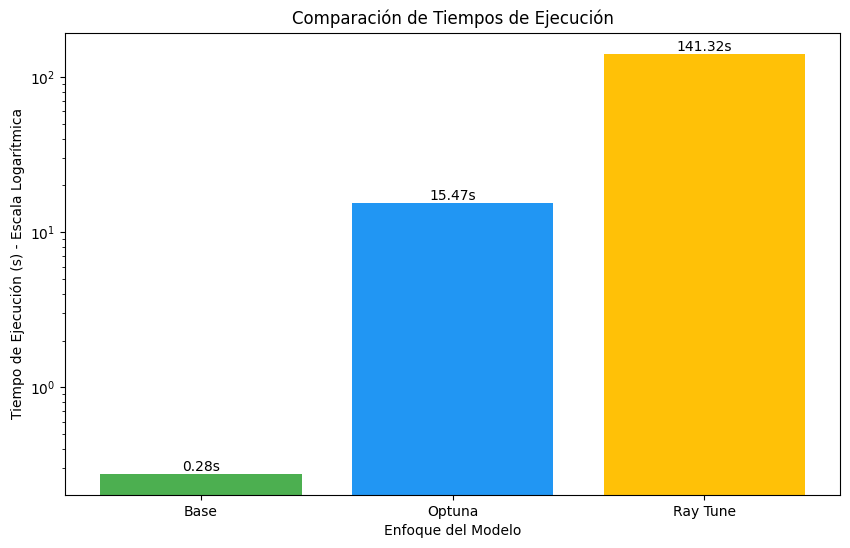

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Recrear los datos del DataFrame para la visualización
comparison_data = {
    'Modelo': ['Base', 'Optuna', 'Ray Tune'],
    'F1-Score': [0.9772, 0.9772, 0.9772],
    'Tiempo (s)': [0.2771, 15.4700, 141.3193]
}
comparison_df = pd.DataFrame(comparison_data)

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
bars = plt.bar(comparison_df['Modelo'], comparison_df['Tiempo (s)'], color=['#4CAF50', '#2196F3', '#FFC107'])

# Usar escala logarítmica para una mejor visualización de las diferencias
plt.yscale('log')

# Añadir etiquetas y título
plt.ylabel('Tiempo de Ejecución (s) - Escala Logarítmica')
plt.xlabel('Enfoque del Modelo')
plt.title('Comparación de Tiempos de Ejecución')

# Añadir el valor de tiempo encima de cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}s', va='bottom', ha='center') # va: vertical alignment

plt.show()

El gráfico ilustra de manera contundente el costo computacional de cada enfoque. Mientras que el modelo base es casi instantáneo, Ray Tune es órdenes de magnitud más lento que Optuna para esta tarea.

-----

### **Reflexión sobre Cada Enfoque 🧠**

#### **Modelo Base (Sin Tuning)**

  * **Ventajas:**
      * **Eficiencia Máxima:** Con un tiempo de solo **0.28 segundos**, es, por mucho, el método más rápido.
      * **Rendimiento Óptimo:** En este caso particular, logró el mejor F1-Score posible sin ningún costo de optimización.
      * **Simplicidad Extrema:** No requiere librerías adicionales ni configuración compleja. Es la línea de partida ideal.
  * **Desventajas:**
      * **Dependencia de la Suerte:** Su éxito aquí es una casualidad afortunada. En la gran mayoría de los problemas, los parámetros por defecto no son los óptimos y confiar en ellos puede llevar a un rendimiento deficiente. No es una estrategia robusta a largo plazo.

#### **Optuna**

  * **Ventajas:**
      * **Búsqueda Relativamente Rápida:** Aunque fue significativamente más lento que el modelo base, completó 20 pruebas en solo **15 segundos**. Esto demuestra que tiene una sobrecarga (overhead) muy baja, haciéndolo ideal para optimizaciones rápidas en una sola máquina.
      * **Facilidad de Uso:** Su API es intuitiva y se integra de forma muy natural en un flujo de trabajo de Python.
  * **Desventajas:**
      * **Costo sin Beneficio (en este caso):** Su principal desventaja aquí fue que invirtió tiempo y recursos computacionales para no obtener ninguna mejora en el rendimiento. El esfuerzo de optimización no se tradujo en un mejor modelo.

#### **Ray Tune**

  * **Ventajas:**
      * **Potencial de Escalabilidad:** Su única ventaja teórica en este contexto. Ray Tune está diseñado para la computación distribuida, permitiendo escalar la búsqueda de hiperparámetros a través de múltiples núcleos de CPU o incluso a un clúster de máquinas. Si necesitáramos ejecutar miles de pruebas, sería la herramienta adecuada.
  * **Desventajas:**
      * **Sobrecarga (Overhead) Masiva:** Esta es su debilidad más evidente aquí. Tardó **141 segundos**, casi **10 veces más que Optuna**, para realizar la misma tarea. La gestión del paralelismo y su arquitectura de escalabilidad introducen un costo computacional fijo muy alto que lo hace ineficiente para problemas a pequeña escala.
      * **Complejidad Innecesaria:** Para una optimización en una sola máquina, su poder es excesivo y contraproducente, resultando en una espera mucho mayor para obtener el mismo resultado que las otras técnicas.

En resumen, para este problema, el **modelo base fue el "ganador" indiscutible** por ofrecer el mismo rendimiento en una fracción del tiempo. Entre las herramientas de tuning, **Optuna demostró ser mucho más adecuado y eficiente que Ray Tune** para una tarea de esta escala.